# Synthetic Dataset Generator for reconstruction

### Nicolas GAUTTIER

This code base is a modular structure to create and store custom datasets for SfM tasks. A unified ToyDataset class is used to defined and construct datasets from given landmarks and cameras, or from 3d models by creating realistic observations

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import open3d as o3d

from src import (
    ToyModel, ToyModel_From_PointCloud, ToyModel_From_SavedNPZ,
    cam_to_world_inversion, get_projection_matrices, camera_positions_arccircle,
    lognormal_focal_length_generator, get_visualiser_camera_parameters,
    gaussian_landmarks_homogeneous, load_pcd,
)

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


## Step 1 : creating a dataset

### 1.1 From custom landmarks and cameras

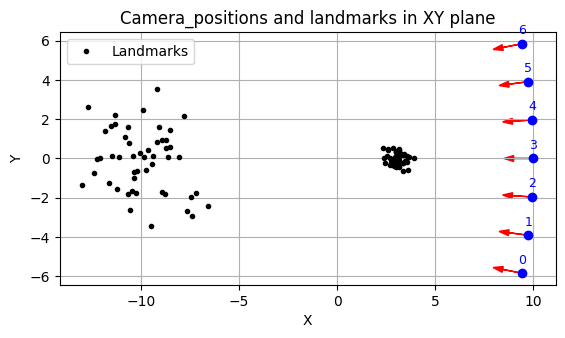

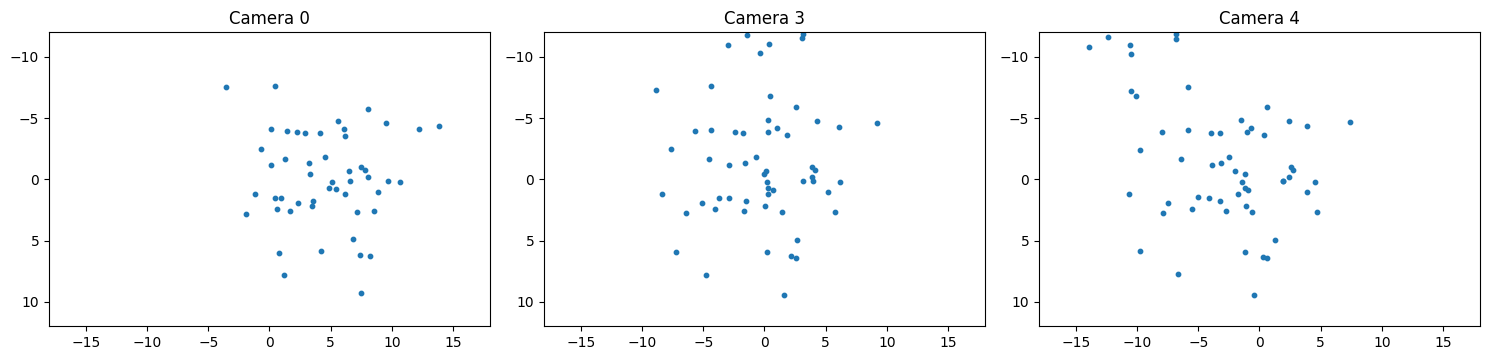

In [8]:
#Enter landmark info
lm_nb = 50
lm_centers = [(3, 0, 2), (-10, 0, 0)]
lm_stddevs = [(0.3, 0.3, 0.3), (1.5, 1.5, 1.5)]

# Enter camera info
cam_nb = 7
cam_center = [-20, 0, 0]
cam_radius = 30
cam_radial_range = np.pi/8
focal_length = 50
principal_point = (0, 0)
sensor_size = (36, 24)

path = '/Data/gautt/bundle_adjustment/robust_povar/data_custom/toydataset.txt'
Write = False

# Computations
intrinsics = np.array([[focal_length, 0, principal_point[0]], [0, focal_length, principal_point[1]], [0, 0, 1]])
cam_positions = camera_positions_arccircle(radial_range=cam_radial_range, radius=cam_radius, cam_nb=cam_nb, center=cam_center)
landmarks = gaussian_landmarks_homogeneous(lm_centers, lm_stddevs, lm_nb)
gaussian_toy_model = ToyModel(landmarks=landmarks,
                              intrinsics=intrinsics, 
                              sensor_sizes=sensor_size,
                              cam_to_world=cam_positions
                              )

# Method to project all landmarks onto the sensor, whose sizes are considered infinite (no clipping at this point)
gaussian_toy_model.project_no_clipping()


# Visualizations
gaussian_toy_model.visualize_cameras_2d(plane='xy', scale=1)
gaussian_toy_model.visualize_projections(show_which_cam=[0,3,4])


## 1.2 From a previously saved dataset

You have the options to reload a dataset instance saved as .npz in ./saved_toy_dataset/ using the following constructor :

In [3]:
recovered = ToyModel_From_SavedNPZ(".\saved_toy_dataset\courthouse_voxel0.02_6million_landmarks.npz")

## 1.3 From a 3d Point Cloud

Please import Courthouse.ply or another point cloud 3D model from Tanks and Temples dataset inside 3d_models.
The bigger the voxel_size, te bigger the downsampling, the quicker the computation, the smaller the number of points

In [4]:
#Load the point cloud and downsample

downpcd = load_pcd(file_path='./3d_models/Courthouse.ply', voxel_size=0.025)

print(f"Number of landmarks = {len(downpcd.points)}")

Number of landmarks = 7313020


In [ ]:
# The Pointcloud itself can be visualized this way

o3d.visualization.draw_geometries([downpcd])

In [5]:
# The function is used to store the point of view you were before you closed the window
_ , cam_to_world = get_visualiser_camera_parameters(downpcd)

Camera position and orientation (camera_to_world):
[[ -0.83944918   0.15644201  -0.52043345  64.54627341]
 [  0.46365489  -0.29334526  -0.83604587   6.16085517]
 [ -0.28345938  -0.94311954   0.17371333 -19.58902679]]
Camera Intrinsic matrix:
[[935.30743609   0.         959.5       ]
 [  0.         935.30743609 539.5       ]
 [  0.           0.           1.        ]]
Camera position: [ 64.54627341   6.16085517 -19.58902679]


In [6]:
#Example with one camera

cam_positions = np.array([cam_to_world])
intrinsics = np.array([[18, 0, 0], [0, 18, 0], [0, 0, 1]], dtype=np.float64)

courthouse_1cam = ToyModel_From_PointCloud(pcd=downpcd,
                                            intrinsics=intrinsics,
                                            cam_to_world=cam_positions)

#Visualize Point Cloud and cameras
courthouse_1cam.visualize_3D()

Camera position and orientation (camera_to_world):
[[ 6.64614084e-01  5.27321864e-01  5.29357886e-01  2.42647423e+01]
 [-6.40052963e-01  3.62574876e-02  7.67474820e-01 -5.69946462e+01]
 [ 3.85513065e-01 -8.48891658e-01  3.61611158e-01 -1.62361704e+01]]
Camera Intrinsic matrix:
[[935.30743609   0.         959.5       ]
 [  0.         935.30743609 539.5       ]
 [  0.           0.           1.        ]]
Camera position: [ 24.26474229 -56.99464623 -16.23617039]
Camera position and orientation (camera_to_world):
[[  0.14313614   0.79761801  -0.58593306  76.91115909]
 [ -0.3018843   -0.5286292   -0.79335808  15.23996489]
 [ -0.94253802   0.2904422    0.16512241 -21.4958043 ]]
Camera Intrinsic matrix:
[[935.30743609   0.         959.5       ]
 [  0.         935.30743609 539.5       ]
 [  0.           0.           1.        ]]
Camera position: [ 76.91115909  15.23996489 -21.4958043 ]


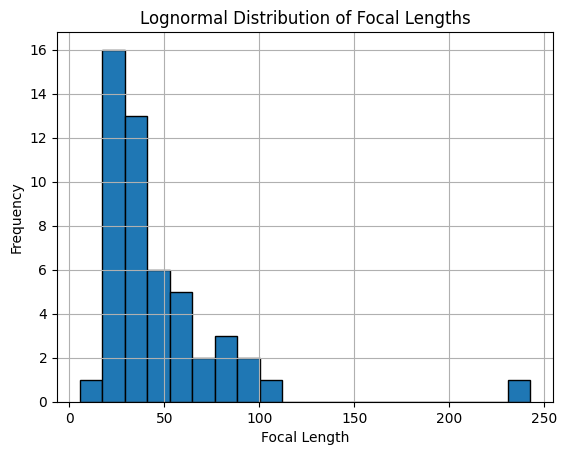

In [7]:
#Example with 50 camera and random intrinsics

#First window : position yourself at the center of the arcircle of cameras you want to define
_ , center_pose = get_visualiser_camera_parameters(downpcd)
#Second window : position yourself midway through the arccircle
_ , target_pose = get_visualiser_camera_parameters(downpcd)


center_to_target = target_pose[:,3] - center_pose[:,3]
radius = np.linalg.norm(center_to_target)

cam_positions = camera_positions_arccircle(radial_range=np.pi / 2,
                                           radius = radius, cam_nb=50,
                                           center=center_pose[:,3], radial_offset=1,
                                           radius_noise_stddev=0.05,
                                           translation_noise_stddev=1,
                                           rotation_angle_noise_stddev=np.pi/25)


intrinsics = lognormal_focal_length_generator(cam_nb=50, mean=3.7, sigma=0.6, show_distribution=True)

courthouse_50cam = ToyModel_From_PointCloud(pcd=downpcd,
                                            intrinsics=intrinsics,
                                            cam_to_world=cam_positions)


#Visualize Point Cloud and cameras
courthouse_50cam.visualize_3D()

# Step 2 : projecting

## Simple Projection - no clipping


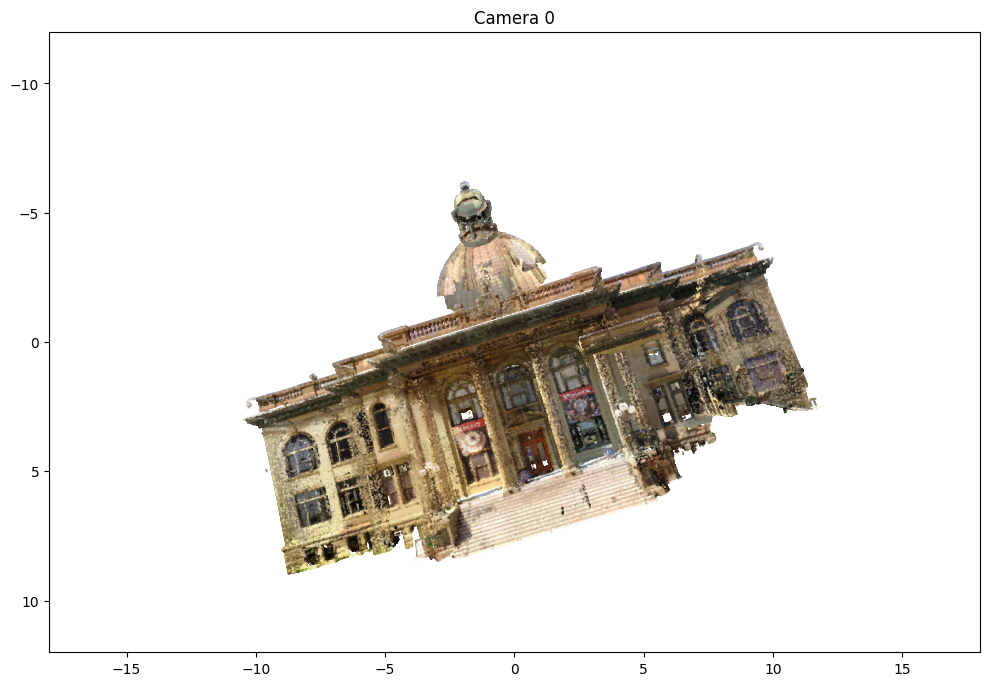

In [8]:
courthouse_1cam.project_no_clipping()
courthouse_1cam.visualize_projections(sphere_size=0.03, fig_size=10)

We can see that all points are projected without any sense of transparancy

## Z-buffering for occlusion elimination.

An Z-buffering technic adapted to point clouds was used to remove normaly unseen points.

- The method requires to carefully tune buffering_pixel_nb and buffer_tolerance depending on the number of landmarkds

- The method works best with a large number of points in the points clouds, but also gets slower as the point cloud grows : aims between 1 million and 10 million for 50 cameras for example. Downsampling can be done once the Z-buffering is over with a lot of points

- Always do this calibration with one camera in the model before computing the whole dataset because it can be computationnally heavy



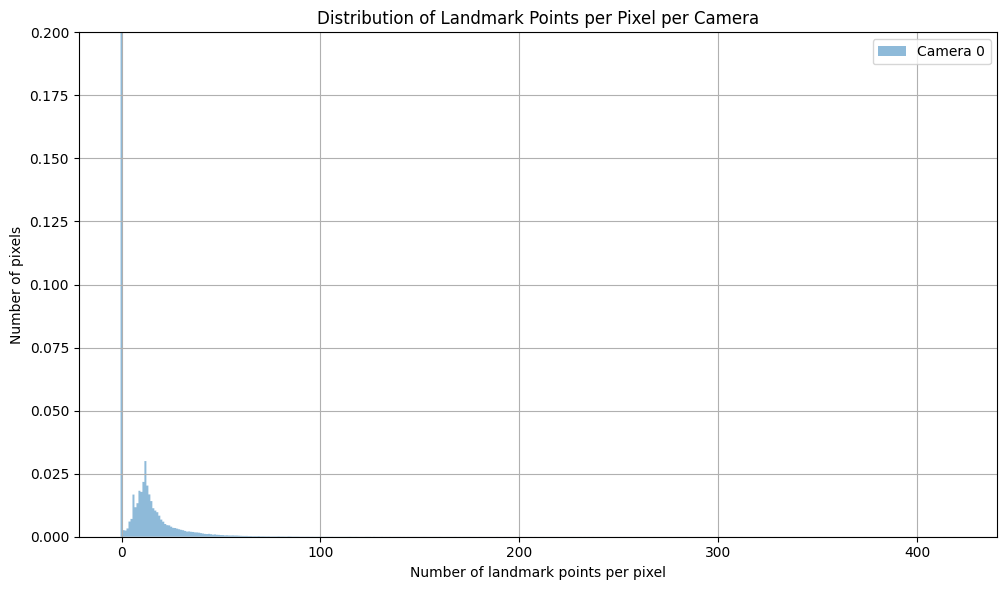

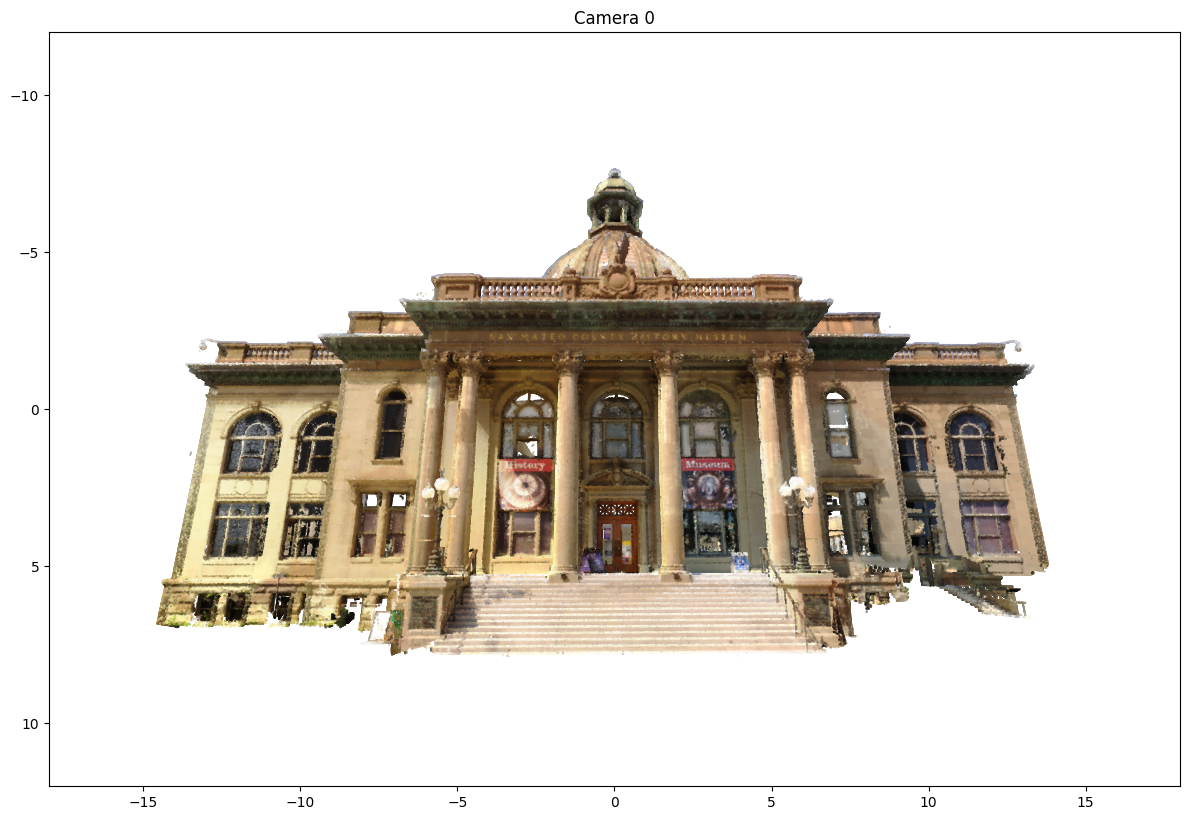

In [14]:
# well calibrated example

well_calibrated_observations = courthouse_1cam.get_observations_Zbuffered(buffering_pixel_nb=(750,500), buffer_tolerance=0.02, show_lm_per_pixel_dist=[0])
courthouse_1cam.visualize_projections(sphere_size=0.03, fig_size=12)

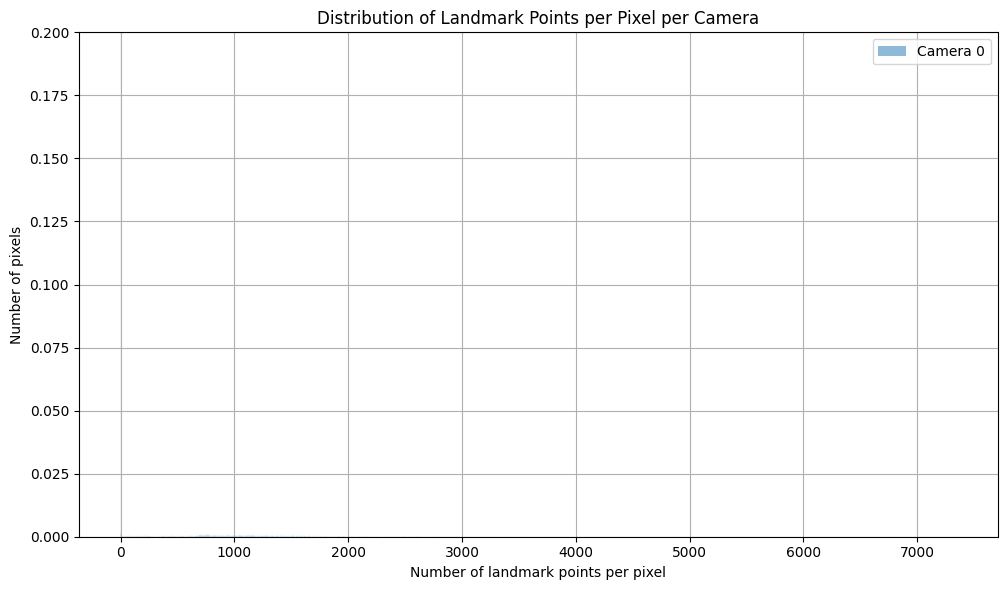

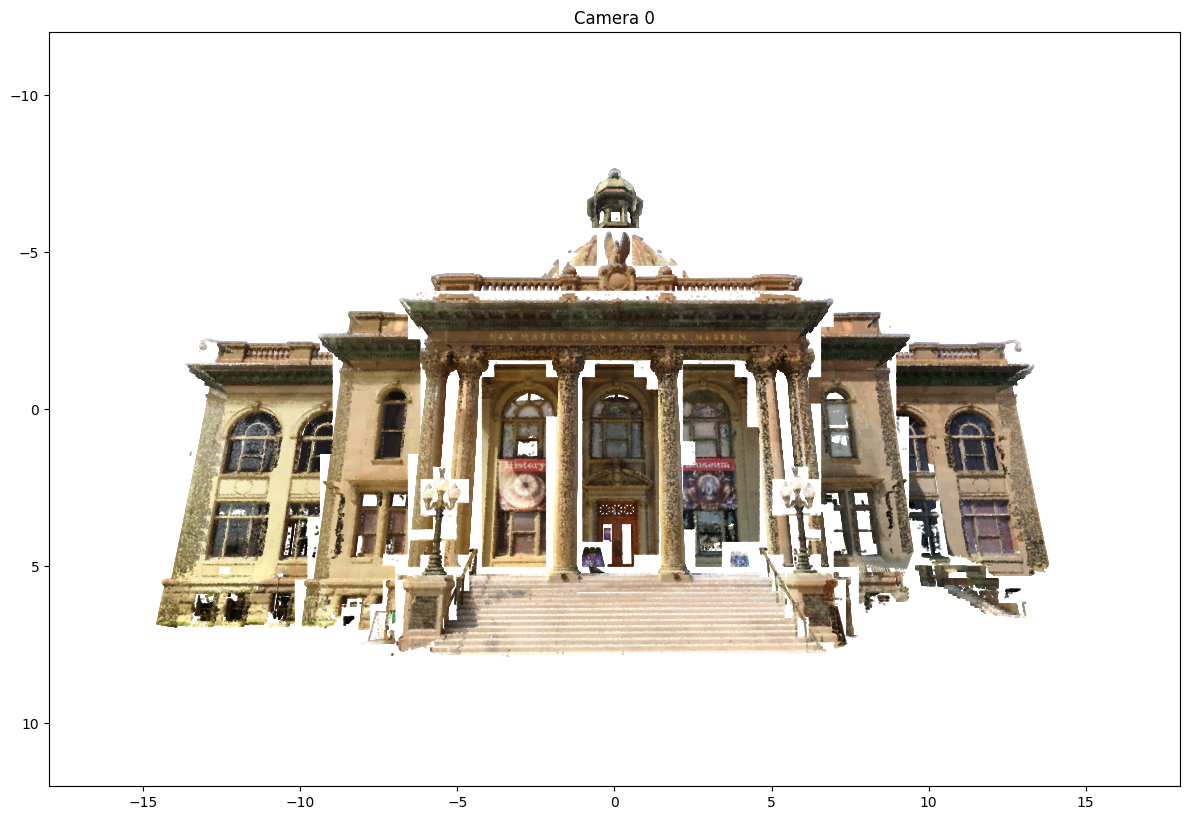

In [15]:
#Too few buffering_pixels

poorly_calibrated_observations = courthouse_1cam.get_observations_Zbuffered(buffering_pixel_nb=(90,60), show_lm_per_pixel_dist=[0])
courthouse_1cam.visualize_projections(sphere_size=0.03, fig_size=12)

The histogram helps figure out how many landmarks fall in a buffering_pixel. Aim for around 10, try to avoid peaks near 1 : occulted pixels would make it through. Peak at 0 is normal : loads of pixels contain no landmarks

In [17]:
#You can run this script to visualize which points are kept or discarded. Useful to calibrate buffer tolerance.
#If tolerance is too high, we will keep points which we should not

mask = ~ np.isnan(well_calibrated_observations[0, :, 0])
points = np.asarray(downpcd.points)
colors = np.asarray(downpcd.colors)
selected_pcd = o3d.geometry.PointCloud()
selected_pcd.points = o3d.utility.Vector3dVector(points[mask])
selected_pcd.colors = o3d.utility.Vector3dVector(colors[mask])

non_selected_pcd = o3d.geometry.PointCloud()
non_selected_pcd.points = o3d.utility.Vector3dVector(points[~mask])
non_selected_pcd.colors = o3d.utility.Vector3dVector(colors[~mask])



o3d.visualization.draw_geometries([selected_pcd])
o3d.visualization.draw_geometries([non_selected_pcd])
o3d.visualization.draw_geometries([downpcd])

# Step 3 : compute the dataset

Once the right parameters for Z-buffering are found with one camera, the dataset can be created with all cameras using remove_occlusions_and_downsample. Choose the voxel_size to downsample the dataset

In [ ]:
courthouse_50cam.remove_occlusions_and_downsample(buffering_pixel_nb=(750,500), buffer_tolerance=0.02, voxel_size=0.2)

In [ ]:
# courthouse_50cam = ToyModel_From_SavedNPZ("saved_toy_dataset\courthouse_voxel0.02_6million_landmarks.npz")

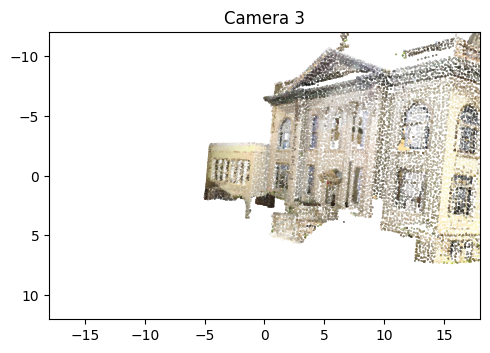

In [10]:
courthouse_50cam.visualize_projections(sphere_size=0.1, show_which_cam=[3])
courthouse_50cam.visualize_3D()

In [21]:
#To recover the instance of the class without redoing the computation
courthouse_50cam.save_to_NPZfile("saved_toy_dataset/courthouse_voxel0.02_6million_landmarks.npz")

#To export a .txt with ground truths
courthouse_50cam.export_observations_and_ground_truths("exports/courthouse_50camsarccircle_voxel0.2_GroundTruths")

#To export a .txt with random initialization for testing in recontruction
random_extrinsics = np.random.normal(size=(courthouse_50cam.cam_nb, 3, 4))
random_landmarks = np.random.normal(size=(courthouse_50cam.lm_nb, 3))

courthouse_50cam.export_observations_with_random_initialization("exports/courthouse_50camsarccircle_voxel0.2_N(0,1)init.txt",
                                                                init_cartesian_landmarks=random_landmarks,
                                                                init_extrinsics=random_extrinsics)

# Read the results

In [11]:
with open("import_results/courthouse_no_upgrade.txt", 'r') as f:
    lines = f.readlines()

cam_nb, lm_nb = map(int, lines[0].split())

idx = 1
# Read extrinsics and sensor sizes
extrinsics = []
for _ in range(cam_nb):
    extrinsic_flat = list(map(float, lines[idx].split()))
    extrinsic = np.array(extrinsic_flat).reshape((3, 4))
    idx += 1

    extrinsics.append(extrinsic)

# Read landmarks
landmarks = []
for i in range(lm_nb):
    x, y, z = map(float, lines[idx].split())
    landmarks.append(np.array([x, y, z]))

    idx += 1

landmarks = np.array(landmarks)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(landmarks)
pcd.colors = o3d.utility.Vector3dVector(courthouse_50cam.colors)

o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 


In [12]:
with open("import_results/courthouse_upgrade.txt", 'r') as f:
    lines = f.readlines()

cam_nb, lm_nb = map(int, lines[0].split())

idx = 1
# Read extrinsics and sensor sizes
extrinsics = []
for _ in range(cam_nb):
    extrinsic_flat = list(map(float, lines[idx].split()))
    extrinsic = np.array(extrinsic_flat).reshape((3, 4))
    idx += 1

    extrinsics.append(extrinsic)

# Read landmarks
landmarks = []
for i in range(lm_nb):
    x, y, z = map(float, lines[idx].split())
    landmarks.append(np.array([x, y, z]))

    idx += 1

landmarks = np.array(landmarks)

pcd = o3d.geometry.PointCloud()
pcd.points = o3d.utility.Vector3dVector(landmarks)
pcd.colors = o3d.utility.Vector3dVector(courthouse_50cam.colors)

o3d.visualization.draw_geometries([pcd])

[Open3D WARNING] GLFW Error: WGL: Failed to make context current: The requested transformation operation is not supported. 
